<a href="https://colab.research.google.com/github/Sindhuhar/practice_AI_projects/blob/main/smile_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smile detection with OpenCV, Keras, and TensorFlow


### Import Packages

In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from pyimagesearch.nn.conv import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Training the Smile CNN

In [4]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset of faces")
#ap.add_argument("-m", "--model", required=True,
#	help="path to output model")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "dataset": "dataset/SMILEsmileD",
    "model": "output/lenet.hdf5"

}

# initialize the list of data and labels
data = []
labels = []

In [5]:
# loop over the input images
for imagePath in sorted(list(paths.list_images(args["dataset"]))):
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = imutils.resize(image, width=28)
	image = img_to_array(image)
	data.append(image)

	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-3]
	label = "smiling" if label == "positives" else "not_smiling"
	labels.append(label)

In [6]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = to_categorical(le.transform(labels), 2)

In [7]:
# calculate the total number of training images in each class and
# initialize a dictionary to store the class weights
classTotals = labels.sum(axis=0)
classWeight = dict()

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

In [9]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=1, classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	class_weight=classWeight, batch_size=64, epochs=15, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/15
165/165 [==============================] - 45s 257ms/step - loss: 0.7746 - accuracy: 0.7130 - val_loss: 0.4745 - val_accuracy: 0.7778
Epoch 2/15
165/165 [==============================] - 27s 165ms/step - loss: 0.5073 - accuracy: 0.8463 - val_loss: 0.3619 - val_accuracy: 0.8435
Epoch 3/15
165/165 [==============================] - 29s 176ms/step - loss: 0.4484 - accuracy: 0.8714 - val_loss: 0.3806 - val_accuracy: 0.8355
Epoch 4/15
165/165 [==============================] - 26s 160ms/step - loss: 0.4138 - accuracy: 0.8856 - val_loss: 0.2993 - val_accuracy: 0.8788
Epoch 5/15
165/165 [==============================] - 31s 187ms/step - loss: 0.3960 - accuracy: 0.8918 - val_loss: 0.3661 - val_accuracy: 0.8390
Epoch 6/15
165/165 [==============================] - 27s 166ms/step - loss: 0.3773 - accuracy: 0.8983 - val_loss: 0.2572 - val_accuracy: 0.9016
Epoch 7/15
165/165 [==============================] - 31s 186ms/step - loss: 

In [10]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))

# save the model to disk
print("[INFO] serializing network...")
model.save(args["model"])

[INFO] evaluating network...
42/42 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

 not_smiling       0.95      0.89      0.92      1895
     smiling       0.76      0.89      0.82       738

    accuracy                           0.89      2633
   macro avg       0.85      0.89      0.87      2633
weighted avg       0.90      0.89      0.89      2633

[INFO] serializing network...


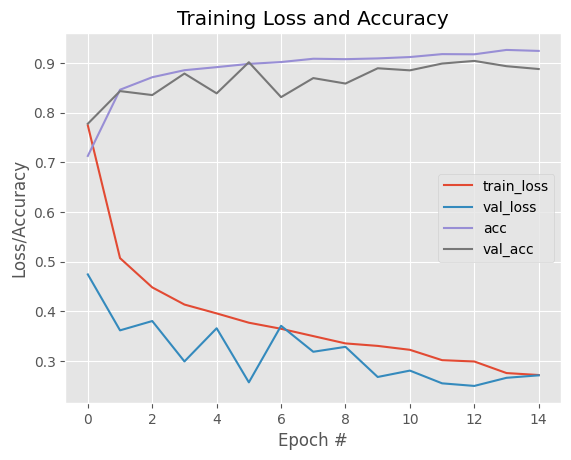

In [11]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Running the Smile CNN on Videos

In [12]:
# first, let's get a video on which we can run our smile detector
!wget https://colab-notebook-videos.s3.us-west-2.amazonaws.com/smile_detection.mp4

--2023-11-14 07:21:20--  https://colab-notebook-videos.s3.us-west-2.amazonaws.com/smile_detection.mp4
Resolving colab-notebook-videos.s3.us-west-2.amazonaws.com (colab-notebook-videos.s3.us-west-2.amazonaws.com)... 3.5.87.152, 52.92.208.170, 52.218.247.193, ...
Connecting to colab-notebook-videos.s3.us-west-2.amazonaws.com (colab-notebook-videos.s3.us-west-2.amazonaws.com)|3.5.87.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4829629 (4.6M) [video/mp4]
Saving to: ‘smile_detection.mp4’

smile_detection.mp4 100%[===================>]   4.61M  5.11MB/s    in 0.9s    

2023-11-14 07:21:21 (5.11 MB/s) - ‘smile_detection.mp4’ saved [4829629/4829629]



In [13]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-c", "--cascade", required=True,
#	help="path to where the face cascade resides")
#ap.add_argument("-m", "--model", required=True,
#	help="path to pre-trained smile detector CNN")
#ap.add_argument("-v", "--video",
#	help="path to the (optional) video file")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "cascade": "haarcascade_frontalface_default.xml",
    "model": "output/lenet.hdf5",
    "video": "smile_detection.mp4",
    "output": "output.avi"
}

In [14]:
# load the face detector cascade and smile detector CNN
detector = cv2.CascadeClassifier(args["cascade"])
model = load_model(args["model"])

# if a video path was not supplied, grab the reference to the webcam
if not args.get("video", False):
	camera = cv2.VideoCapture(0)

# otherwise, load the video
else:
	camera = cv2.VideoCapture(args["video"])

# initialize pointer to output video file
writer = None

In [15]:
# keep looping
while True:
	# grab the current frame
	(grabbed, frame) = camera.read()

	# if we are viewing a video and we did not grab a frame, then we
	# have reached the end of the video
	if args.get("video") and not grabbed:
		break

	# resize the frame, convert it to grayscale, and then clone the
	# original frame so we can draw on it later in the program
	frame = imutils.resize(frame, width=300)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	frameClone = frame.copy()

    # detect faces in the input frame, then clone the frame so that
	# we can draw on it
	rects = detector.detectMultiScale(gray, scaleFactor=1.1,
		minNeighbors=5, minSize=(30, 30),
		flags=cv2.CASCADE_SCALE_IMAGE)

    # loop over the face bounding boxes
	for (fX, fY, fW, fH) in rects:
		# extract the ROI of the face from the grayscale image,
		# resize it to a fixed 28x28 pixels, and then prepare the
		# ROI for classification via the CNN
		roi = gray[fY:fY + fH, fX:fX + fW]
		roi = cv2.resize(roi, (28, 28))
		roi = roi.astype("float") / 255.0
		roi = img_to_array(roi)
		roi = np.expand_dims(roi, axis=0)

        # determine the probabilities of both "smiling" and "not
		# smiling", then set the label accordingly
		(notSmiling, smiling) = model.predict(roi)[0]
		label = "Smiling" if smiling > notSmiling else "Not Smiling"

        # display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frameClone, label, (fX, fY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
		cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
			(0, 0, 255), 2)

	# if the video writer is None *AND* we are supposed to write
	# the output video to disk initialize the writer
	if writer is None and args["output"] is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 20,
			(frameClone.shape[1], frameClone.shape[0]), True)

	# if the writer is not None, write the frame to disk
	if writer is not None:
		writer.write(frameClone)

# do a bit of cleanup
camera.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()

1/1 [==============================] - 0s 41ms/step


Note that the above code block may take time to execute. If you are interested to view the video within Colab just execute the following code blocks. Note that it may be time-consuming.

Our output video is produced in `.avi` format. First, we need to convert it to `.mp4` format.

In [16]:
!ffmpeg -i output.avi output.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [17]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)